In [1]:
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import os
import json
from tqdm import tqdm 
from skimage import transform, filters
import matplotlib.pyplot as plt
from VQA_blocks import *
from Data_loader import *
from matplotlib import cm as c

Using TensorFlow backend.


In [2]:
embed_size = 300
q_len = 26
height = 224
width = 224
lstm_units = 256
attention_dim = 512
num_output = 1000

batch_size = 56
lr = 0.0005

In [3]:
loss, image_inp, question_inp, true_label , attention_layers , pred_label =   SAN(
                                                                                height,
                                                                                width, 
                                                                                q_len,
                                                                                embed_size, 
                                                                                lstm_units, 
                                                                                attention_dim, 
                                                                                num_output, 
                                                                                batch_size
                                                                                )

print("Model Loaded")
print("Input image dimensions : ",image_inp.shape)
print("Input question embedding dimension : ", question_inp.shape)
print("True Answers Dimensions : " , true_label.shape)
print("Attention matrix dimensions : " ,attention_layers[0].shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(56, 1000) (56,)
(56, 1000)
Model Loaded
Input image dimensions :  (56, 224, 224, 3)
Input question embedding dimension :  (56, 26, 300)
True Answers Dimensions :  (56,)
Attention matrix dimensions :  (56, 196)


In [4]:
data_gen = load_data(batch_size)

In [5]:
image , question , answer , ids = next(data_gen)
print(ids)

/home/neeraj/anaconda3/envs/deep_learning/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[466262001 281496002 576155011 506691004 146004008 522416003 381251000
 295285000 157434000   3225001 411705000 325242005 204382006 171737000
 320436002 296614002 338438000 265233005 195213000 112720002 369805001
 498562001 471731002 555062000 293366001 239739003 429643004 119525004
 512806001 295659001 330737000 260393001 231148012  40338003 181584004
 554083001 330907009 312946012 436521001 210124002   5684001  21566000
 553554001 412687004 150225001 101575004 581056001 380449011 539395005
 535994002  28823003 191639002  57075000 481125000 165636002 251121007]


In [6]:
train_op = tf.train.AdamOptimizer(lr).minimize(loss)
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [7]:
epochs = 1
total_size = 388158
loss_data = []
tot_loss = 0

In [8]:
with tf.Session() as sess:
    
    saver.restore(sess, "train_model/model.ckpt")
    
    print("Restored")
    
    for i in range(epochs):
        
        num_iters = int(total_size/batch_size)
        
        for iters in tqdm(range(176,num_iters)):
            
            image,question,answer,ids = next(data_gen)
            
            _ , loss_out = sess.run([train_op,loss] , feed_dict = {image_inp:image , question_inp:question , true_label : answer} )
            
            tot_loss = tot_loss + loss_out
            
            if iters % 150 == 0:
                save_path = saver.save(sess, "train_model/model.ckpt")

            
        loss_data.append(tot_loss/num_iters)
        
        save_path = saver.save(sess, "train_model/model.ckpt")
        print("Model Saved")
        np.save('Loss/'+str(i)+'.npy' , np.array(loss_data))
        
    

In [9]:
def attention(img, att_map):
    
    att_map = np.reshape(att_map, [14,14])
    att_map = att_map.repeat(16, axis=0).repeat(16, axis=1)
    att_map = np.tile(np.expand_dims(att_map, 2),[1,1,3])
    att_map[:,:,1:] = 0
    # apply gaussian
    att_map = filters.gaussian(att_map, sigma=7)
    att_map = (att_map-att_map.min()) / att_map.max()
    att_map = cv2.resize(att_map, (img.shape[1], img.shape[0]))
    new_img = 255*att_map*0.6 + 255*img*0.4

    return new_img


def get_pred(images ,answer ,pred_answer,questions_str , att_m):
    num = np.random.randint(0,batch_size , 10)
    
    for i in range(num.shape[0]):
        #atts = attention((images[num[i]] + 1)/2 , att_m[num[i]] )
        print("Image : ")
        plt.imshow((image[num[i]] + 1)/2)
        plt.show()
        #print(atts[0])
        print("Question : " , questions_str[num[i]])
        print("Predicted Answer : " , ans_map[str(pred_answer[num[i]])])
        print("True Answer : " , ans_map[str(answer[num[i]])])
        #print("Attention Map : ")
        #plt.imshow(atts)
        #plt.show()
        print("")    

In [34]:
image , question , answer , ids = next(data_gen)
questions_str = []

imgs_train = json.load(open('Raw_Data/vqa_raw_train.json' , 'r'))
ans_map = json.load(open('train.json' , 'r'))

for i in tqdm(range(ids.shape[0])):
    for j in range(len(imgs_train)):        
        if imgs_train[j]['ques_id'] == ids[i]:
            questions_str.append(imgs_train[j]['question'])

print("Questions Loaded")
    
with tf.Session() as sess:

        saver.restore(sess, "train_model/model.ckpt")
        ans , atts = sess.run([pred_label,attention_layers[1]] , feed_dict = {image_inp:image , question_inp:question } )
        pred_answer = np.argmax(ans , axis = 1)

100%|██████████| 56/56 [00:08<00:00,  6.44it/s]

Questions Loaded
INFO:tensorflow:Restoring parameters from train_model/model.ckpt


Image : 


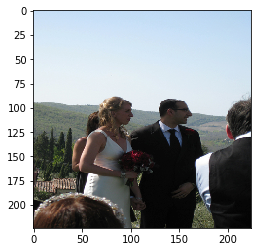

Question :  What is on the man's face?
Predicted Answer :  glasses
True Answer :  glasses

Image : 


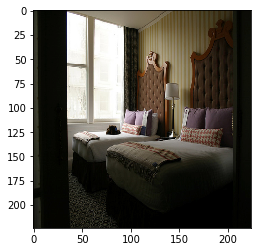

Question :  Has this bed been slept in?
Predicted Answer :  no
True Answer :  no

Image : 


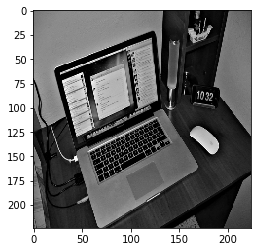

Question :  Is the laptop on?
Predicted Answer :  yes
True Answer :  yes

Image : 


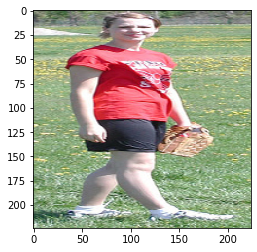

Question :  What color shirt is the taller girl wearing?
Predicted Answer :  black
True Answer :  red

Image : 


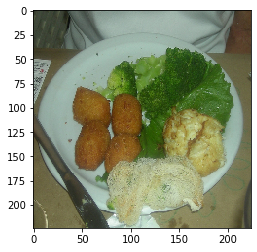

Question :  Is this being served at home?
Predicted Answer :  yes
True Answer :  yes

Image : 


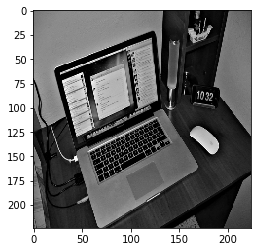

Question :  Is the laptop on?
Predicted Answer :  yes
True Answer :  yes

Image : 


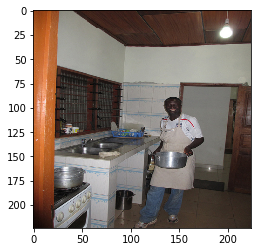

Question :  What is the person holding?
Predicted Answer :  tennis racket
True Answer :  pot

Image : 


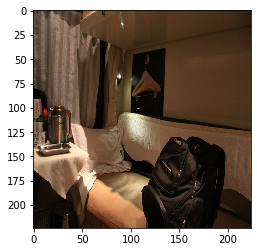

Question :  Where is the insulated mug?
Predicted Answer :  on table
True Answer :  table

Image : 


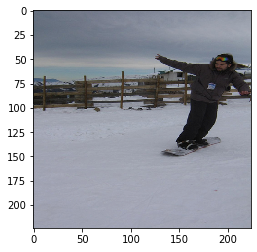

Question :  Is this person a professional?
Predicted Answer :  no
True Answer :  no

Image : 


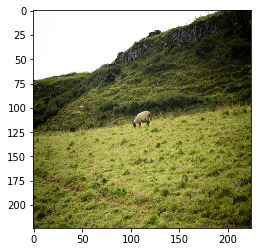

Question :  How many animals?
Predicted Answer :  1
True Answer :  1



In [35]:
get_pred(image ,answer,pred_answer,questions_str , atts)